In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# CPSC 330 - Applied Machine Learning

## Homework 8: Introduction to Computer vision and Time Series (Lectures 19 and 20) 

**Due date: see the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330/blob/master/docs/calendar.html).**

## Imports

In [2]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023W1/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb.

<br><br>

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset and storing it under the `data` folder. We will be forcasting average avocado price for the next week. 

In [3]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.shape

(18249, 13)

In [5]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [6]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [7]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [8]:
assert len(df_train) + len(df_test) == len(df)

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many time series? 
rubric={points:4}

In the [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) dataset from lecture demo, we had different measurements for each Location. 

We want you to consider this for the avocado prices dataset. For which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 4

Yes, we have measurements on the same day at different regions with different types.

In [9]:
df.sort_values(by=["Date","region","type"]).head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
51,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
51,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
51,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta
51,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,BaltimoreWashington


In [10]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Equally spaced measurements? 
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

We have exception in "WestTexNewMexico" where has some missing measurements for "organic" type. Except for this, in other regions, the measurements are equally spaced across different types and regions. 7 days would be the spacing for each region and type.

In [11]:
def plot_time_spacing_distribution(df, region="Adelaide", type_val=None): 
    """
    Plots the distribution of time spacing for a given region and type.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'Location', 'Type', and 'Date'.
        region (str): The region (e.g., location) to analyze.
        type_val (str, optional): The specific type to analyze within the region. Defaults to None.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data for the given region and type
    filtered_data = df[df['region'] == region]
    if type_val is not None:
        filtered_data = filtered_data[filtered_data['type'] == type_val]
    
    if filtered_data.empty:
        print(f"No data available for region: {region}" + (f" and type: {type_val}" if type_val else ""))
        return
    
    # Calculate time differences
    time_diffs = filtered_data['Date'].sort_values().diff().dt.days.dropna()
    
    # Count the frequency of each time difference
    value_counts = time_diffs.value_counts().sort_index()
    
    # Display value counts
    type_info = f" and type: {type_val}" if type_val else ""
    print(f"Time spacing counts for {region}{type_info}:\n{value_counts}\n")
    
    # Plot the bar chart
    plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {region}{type_info}")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Time spacing counts for WestTexNewMexico and type: organic:
Date
7.0     163
14.0      1
21.0      1
Name: count, dtype: int64



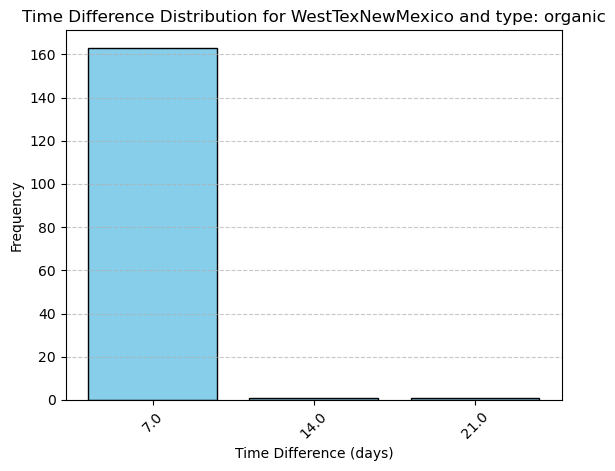

In [12]:
plot_time_spacing_distribution(df, region="WestTexNewMexico", type_val="organic")

Time spacing counts for Albany and type: conventional:
Date
7.0    168
Name: count, dtype: int64



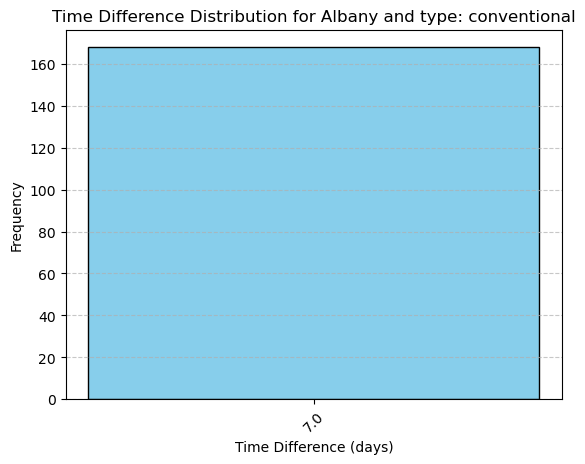

In [13]:

plot_time_spacing_distribution(df, region="Albany", type_val="conventional")

In [14]:
...

Ellipsis

In [15]:
...

Ellipsis

In [16]:
...

Ellipsis

In [17]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Interpreting regions 
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 4

Yes, there are overlapping regions. Here, I list out all unique values in "region". We can see, for example, "TotalUS" intuitively overlaps with all other regions.

In [18]:
value_region = df['region'].value_counts()
print(value_region)

region
Albany                 338
Sacramento             338
Northeast              338
NorthernNewEngland     338
Orlando                338
Philadelphia           338
PhoenixTucson          338
Pittsburgh             338
Plains                 338
Portland               338
RaleighGreensboro      338
RichmondNorfolk        338
Roanoke                338
SanDiego               338
Atlanta                338
SanFrancisco           338
Seattle                338
SouthCarolina          338
SouthCentral           338
Southeast              338
Spokane                338
StLouis                338
Syracuse               338
Tampa                  338
TotalUS                338
West                   338
NewYork                338
NewOrleansMobile       338
Nashville              338
Midsouth               338
BaltimoreWashington    338
Boise                  338
Boston                 338
BuffaloRochester       338
California             338
Charlotte              338
Chicago              

In [19]:
...

Ellipsis

In [20]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price. The function below is adapted from [Lecture 19](https://github.com/UBC-CS/cpsc330-2023W1/tree/main/lectures), with some improvements.

In [21]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [22]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [23]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


Our goal is to predict `AveragePriceNextWeek`. 

Let's split the data:

In [24]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 `AveragePrice` baseline 
rubric={points}

Soon we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML though, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get on the train and test data?

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

Through the baseline approach,

$R^2$ on the train data: 0.8285800937261841

$R^2$ on the test data: 0.7631780188583048

In [25]:
# r2_score(y_true, y_pred)
df_train["DummyPrediction"] = df_train["AveragePrice"]
train_r2 = r2_score(df_train["AveragePriceNextWeek"],df_train["DummyPrediction"])
train_r2

C:\Users\wr201\AppData\Local\Temp\ipykernel_16132\847884460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["DummyPrediction"] = df_train["AveragePrice"]


0.8285800937261841

In [26]:
df_test["DummyPrediction"] = df_test["AveragePrice"]
test_r2 = r2_score(df_test["AveragePriceNextWeek"],df_test["DummyPrediction"])
test_r2

C:\Users\wr201\AppData\Local\Temp\ipykernel_16132\4007012157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["DummyPrediction"] = df_test["AveragePrice"]


0.7631780188583048

In [27]:
...

Ellipsis

In [28]:
...

Ellipsis

In [29]:
assert not train_r2 is None, "Are you using the correct variable name?"
assert not test_r2 is None, "Are you using the correct variable name?"
assert sha1(str(round(train_r2, 3)).encode('utf8')).hexdigest() == 'b1136fe2a8918904393ab6f40bfb3f38eac5fc39', "Your training score is not correct. Are you using the right features?"
assert sha1(str(round(test_r2, 3)).encode('utf8')).hexdigest() == 'cc24d9a9b567b491a56b42f7adc582f2eefa5907', "Your test score is not correct. Are you using the right features?"

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Forecasting average avocado price
rubric={points:10}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 10

I tried 3 ways to encode dates.
1. Encoding dates as number. $R^2$ on test data:0.78. The score is not improved, so I decided to make dates as categorical variable, such as month.
2. Encoding dates as month. $R^2$ on test data:0.80. The score is improved. To explore more, I decided to make a more general categorical variable, season, to check the score.
3. Encoding dates as season. $R^2$ on test data:0.79. Looks like season doesn't have effect as much as I expected, better than the first approach, but lower than encoding as month.

So encoding dates as month would work best.
The result makes sense a bit because avocado price is affected by the time of the year.

In [30]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 15441 entries, 0 to 18222
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  15441 non-null  datetime64[ns]
 1   AveragePrice          15441 non-null  float64       
 2   Total Volume          15441 non-null  float64       
 3   4046                  15441 non-null  float64       
 4   4225                  15441 non-null  float64       
 5   4770                  15441 non-null  float64       
 6   Total Bags            15441 non-null  float64       
 7   Small Bags            15441 non-null  float64       
 8   Large Bags            15441 non-null  float64       
 9   XLarge Bags           15441 non-null  float64       
 10  type                  15441 non-null  object        
 11  year                  15441 non-null  int64         
 12  region                15441 non-null  object        
 13  AveragePriceNextWeek 

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek,DummyPrediction
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24,1.22
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17,1.24
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06,1.17
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99,1.06
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99,0.99


In [31]:
numeric_features = [
    "AveragePrice",
    "Total Volume",
    "4046",
    "4225",
    "4770",
    "Total Bags",
    "Small Bags",
    "Large Bags",
    "XLarge Bags",
    "year"
                   ]
categorical_features = [
    "type",
    "region",
]
drop_features = ["Date"]
target = ["AveragePriceNextWeek"]

In [32]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df["AveragePriceNextWeek"]
    y_test = test_df["AveragePriceNextWeek"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [33]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    df_train,
    df_test,
    numeric_features,
    categorical_features,
    drop_features + ["DummyPrediction"], target
)

In [34]:
from sklearn.linear_model import LinearRegression
def score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc):
    lr_pipe = make_pipeline(preprocessor, LinearRegression())
    lr_pipe.fit(train_df, y_train)
    print("Train score: {:.2f}".format(lr_pipe.score(train_df, y_train)))
    print("Test score: {:.2f}".format(lr_pipe.score(test_df, y_test)))
    lr_coef = pd.DataFrame(
        data=lr_pipe.named_steps["linearregression"].coef_.flatten(),
        index=X_train_enc.columns,
        columns=["Coef"],
    )
    return lr_coef.sort_values(by="Coef", ascending=False)

In [35]:
score_lr_print_coeff(preprocessor, df_train, y_train, df_test, y_test, X_train_enc)

Train score: 0.85
Test score: 0.78


,Coef
region_SanFrancisco,4.077128e+08
region_HartfordSpringfield,4.077128e+08
region_NewYork,4.077128e+08
region_Philadelphia,4.077128e+08
region_Sacramento,4.077128e+08
...,...
XLarge Bags,-2.853609e+03
Large Bags,-3.639047e+04
Small Bags,-1.177210e+05
type_organic,-3.422389e+09


In [36]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
df_train_ordered = df_train.sort_values(by=["Date"])
y_train_ordered = df_train_ordered["AveragePriceNextWeek"]
lr_pipe = make_pipeline(preprocessor, LinearRegression())

In [37]:
# 1.encode date as number
first_day = df_train["Date"].min()

df_train = df_train.assign(
    Days_since=df_train["Date"].apply(lambda x: (x - first_day).days)
)
df_test = df_test.assign(
    Days_since=df_test["Date"].apply(lambda x: (x - first_day).days)
)

In [38]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    df_train,
    df_test,
    numeric_features + ["Days_since"],
    categorical_features,
    drop_features + ["DummyPrediction"], target
)

In [39]:
score_lr_print_coeff(preprocessor, df_train, y_train, df_test, y_test, X_train_enc)

Train score: 0.85
Test score: 0.78


,Coef
type_organic,2.728632e+10
type_conventional,2.728632e+10
region_SanFrancisco,5.620919e+09
region_HartfordSpringfield,5.620919e+09
region_NewYork,5.620919e+09
...,...
4225,-1.784986e+01
4046,-1.844741e+01
XLarge Bags,-2.752835e+03
Large Bags,-3.510536e+04


In [40]:
# 2.encode date as month
df_train = df_train.assign(
    Month=df_train["Date"].apply(lambda x: x.month_name())
)  # x.month_name() to get the actual string
df_test = df_test.assign(Month=df_test["Date"].apply(lambda x: x.month_name()))

In [41]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    df_train,
    df_test,
    numeric_features,
    categorical_features + ["Month"],
    drop_features + ["Days_since"] + ["DummyPrediction"], 
    target
)

In [42]:
score_lr_print_coeff(preprocessor, df_train, y_train, df_test, y_test, X_train_enc)

Train score: 0.85
Test score: 0.80


,Coef
region_SanFrancisco,2.563703e+09
region_HartfordSpringfield,2.563703e+09
region_NewYork,2.563703e+09
region_Philadelphia,2.563703e+09
region_Sacramento,2.563703e+09
...,...
XLarge Bags,-2.113611e+03
Large Bags,-2.695369e+04
Small Bags,-8.719361e+04
type_organic,-1.014313e+09


In [43]:
# 3.encode date as season
def get_season(month):
    # remember this is Australia
    WINTER_MONTHS = ["June", "July", "August"] 
    AUTUMN_MONTHS = ["March", "April", "May"]
    SUMMER_MONTHS = ["December", "January", "February"]
    SPRING_MONTHS = ["September", "October", "November"]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in AUTUMN_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Fall"

df_train = df_train.assign(Season=df_train["Month"].apply(get_season))
df_test = df_test.assign(Season=df_test["Month"].apply(get_season))

In [44]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    df_train,
    df_test,
    numeric_features,
    categorical_features  +  ["Season"],
    drop_features + ["Days_since", "Month"] + ["DummyPrediction"], 
    target
)

In [45]:
score_lr_print_coeff(preprocessor, df_train, y_train, df_test, y_test, X_train_enc)

Train score: 0.85
Test score: 0.79


,Coef
region_SanFrancisco,1.132634e+09
region_HartfordSpringfield,1.132634e+09
region_NewYork,1.132634e+09
region_Philadelphia,1.132634e+09
region_Sacramento,1.132634e+09
...,...
Season_Fall,-3.847481e+09
Season_Autumn,-3.847481e+09
Season_Summer,-3.847481e+09
type_organic,-5.484337e+09


In [46]:
...

Ellipsis

In [47]:
...

Ellipsis

In [48]:
...

Ellipsis

In [49]:
...

Ellipsis

In [50]:
...

Ellipsis

In [51]:
...

Ellipsis

In [52]:
...

Ellipsis

In [53]:
...

Ellipsis

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: Short answer questions

<!-- BEGIN QUESTION -->

### 2.1 Time series

rubric={points:6}

The following questions pertain to Lecture 20 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.
3. When studying time series modeling, we explored several ways to encode date information as a feature for the citibike dataset. When we used time of day as a numeric feature, the Ridge model was not able to capture the periodic pattern. Why? How did we tackle this problem? Briefly explain.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 6

1. For example, weekdays are might affected by long weekends. And each year we might have long weekends on different dates. Then our weekdays are not equally spaced by 5 days.
2. Creating lagged features would struggle with unequally spaced time points because when we lag something, we need a regular time interval pattern. If not, our lagging is not reasonable and not understandable.
But encoding dates as day, month or year is not affected by unequally spaced time points because it just converts date to more features regardless the existence of unequal time points spacing.
3. Because Ridge is linear model which can't capture the periodic pattern of linear variable. We can encode it as categorical variable, like morning or evening. Thus our model can capture the periodic pattern better.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Computer vision 
rubric={points:6}

The following questions pertain to Lecture 19 on multiclass classification and introduction to computer vision. 

1. How many parameters (coefficients and intercepts) will `sklearn`’s `LogisticRegression()` model learn for a four-class classification problem, assuming that you have 10 features? Briefly explain your answer.
2. In Lecture 19, we briefly discussed how neural networks are sort of like `sklearn`'s pipelines, in the sense that they involve multiple sequential transformations of the data, finally resulting in the prediction. Why was this property useful when it came to transfer learning?
3. Imagine that you have a small dataset with ~1000 images containing pictures and names of 50 different Computer Science faculty members from UBC. Your goal is to develop a reasonably accurate multi-class classification model for this task. Describe which model/technique you would use and briefly justify your choice in one to three sentences.

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 6

1. A coefficient is associated with each feature and each class. And for each class there is an intercept.
   So we have 40 coefficients and 4 intercepts.
2. It can help us extract features for new tasks. And these pre_trained neural networks save us time and cost.
3. I will use a pre_trained network, like CNN which has been trained on the ImageNet, to extract features for our data. Then we train a logistic regression as our classifier which is good at classification with high dimensions.

<!-- END QUESTION -->

<br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 

![](img/eva-well-done.png)